# Revised stellar parameters for HelloWorldNet

In [1]:
#! wget https://iopscience.iop.org/0004-637X/866/2/99/suppdata/apjaada83t1_mrt.txt
#! mkdir ../data
#! mv apjaada83t1_mrt.txt ../data/Berger2018_tbl1.txt

In [2]:
! ls ../data/

Berger2018_tbl1.txt


In [3]:
! head -n 40 ../data/Berger2018_tbl1.txt

Title: Revised Radii Of Kepler Stars And Planets Using Gaia Data Release 2 
Authors: Berger T.A., Huber D., Gaidos E., van Saders J.L.
Table: Revised Parameters of Kepler Stars
Byte-by-byte Description of file: apjaada83t1_mrt.txt
--------------------------------------------------------------------------------
   Bytes Format Units    Label  Explanations
--------------------------------------------------------------------------------
   1-  8 I8     ---      KIC    Kepler Input Catalog identifier
  10- 28 I19    ---      Gaia   Gaia DR2 identifier 
  30- 34 I5     K        Teff   Effective temperature
  36- 38 I3     K      e_Teff   Uncertainty in Teff
  40- 48 F9.3   pc       D      Distance  
  50- 57 F8.3   pc     E_D      Upper uncertainty limit in D
  59- 66 F8.3   pc     e_D      Lower uncertainty limit in D
  68- 74 F7.3   solRad   R*     Stellar radius
  76- 81 F6.3   solRad E_R*     Upper uncertainty in R*
  83- 88 F6.3   solRad e_R*     Lower uncertainty in R*
  90- 94 F5.3  

The format requires astropy

In [4]:
from astropy.io import ascii

In [5]:
tab1 = ascii.read('../data/Berger2018_tbl1.txt')

Cool!  Let's send that to pandas.

In [6]:
df = tab1.to_pandas()

In [7]:
keep_cols = ['KIC', 'Teff', 'R*','Evol', 'Bin']

In [8]:
df = df[keep_cols]

In [9]:
df.head()

,KIC,Teff,R*,Evol,Bin
0,757076,5164,3.986,1,0
1,757099,5521,1.053,0,0
2,757137,4751,13.406,2,0
3,757280,6543,2.687,0,0
4,757450,5306,0.962,0,0


In [10]:
df.Bin.value_counts()

0    174446
1      3137
2       323
3         5
Name: Bin, dtype: int64

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Let's "whiten" the data:

In [12]:
df.Teff.describe()

count    177911.000000
mean       5688.569886
std         789.636412
min        3004.000000
25%        5206.000000
50%        5781.000000
75%        6158.000000
max       20870.000000
Name: Teff, dtype: float64

In [13]:
df['Teff_white'] = df['Teff']-df['Teff'].mean()
df['Teff_white'] = df['Teff_white']/np.std(df['Teff_white'])

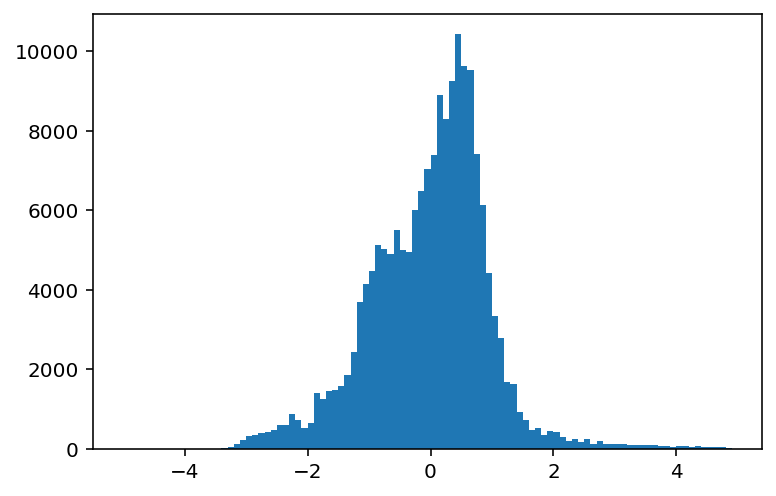

In [14]:
plt.hist(df['Teff_white'], bins=np.arange(-5,5,0.1));

In [15]:
df['R_white'] = df['R*']-df['R*'].mean()
df['R_white'] = df['R_white']/np.std(df['R_white'])

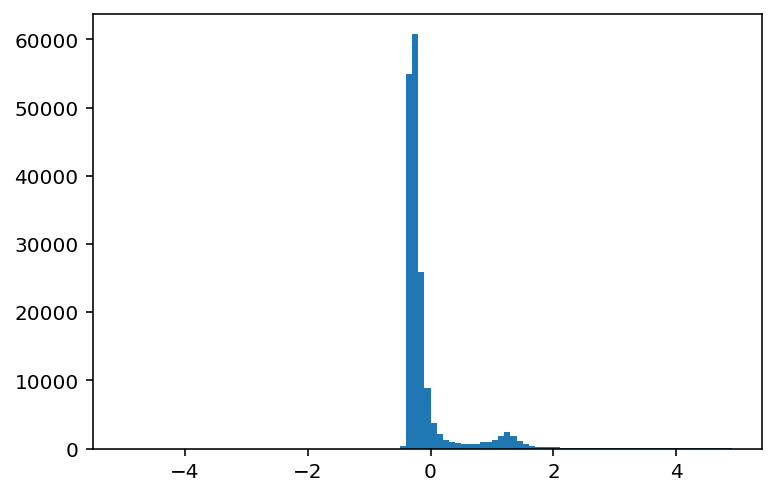

In [16]:
plt.hist(df['R_white'], bins=np.arange(-5,5,0.1));

In [17]:
df = df.drop(columns=['R*', 'Teff'])

OK, we need to map the KIC ids to the info files.  Let's verify which info labels correspond to what stellar properties.

In [18]:
import glob

In [19]:
! ls /Volumes/Truro/ExoNet/exonet_inputs/

test      test_brg  train     train_brg val       val_brg


In [23]:
test_files = glob.glob('/Volumes/Truro/ExoNet/exonet_inputs/test/*info.npy')
train_files = glob.glob('/Volumes/Truro/ExoNet/exonet_inputs/train/*info.npy')
val_files = glob.glob('/Volumes/Truro/ExoNet/exonet_inputs/val/*info.npy')

In [24]:
train_files[0:3]

['/Volumes/Truro/ExoNet/exonet_inputs/train/kplr_000757450_01_info.npy',
 '/Volumes/Truro/ExoNet/exonet_inputs/train/kplr_000892667_01_info.npy',
 '/Volumes/Truro/ExoNet/exonet_inputs/train/kplr_000892772_01_info.npy']

In [25]:
kic_test = [int(string[46:-12]) for string in test_files]
kic_train = [int(string[47:-12]) for string in train_files]
kic_val = [int(string[45:-12]) for string in val_files]

Make a dataframe of the info values.

In [28]:
df_info = pd.DataFrame()

In [29]:
%%time
for file in train_files:
    vec = np.load(file)
    df_info = df_info.append(pd.DataFrame(data=vec).T, ignore_index=True)

CPU times: user 10.5 s, sys: 659 ms, total: 11.1 s
Wall time: 11.1 s


In [30]:
df_out = pd.merge(df, df_info, left_on='KIC', right_on=0, how='outer', indicator=True)

In [31]:
df_out._merge.value_counts()

left_only     170502
both           10597
right_only      1340
Name: _merge, dtype: int64

Again, some stars do not have Gaia measurements.  That's OK.

In [32]:
df_both = df_out[df_out._merge =='both']

In [33]:
import seaborn as sns

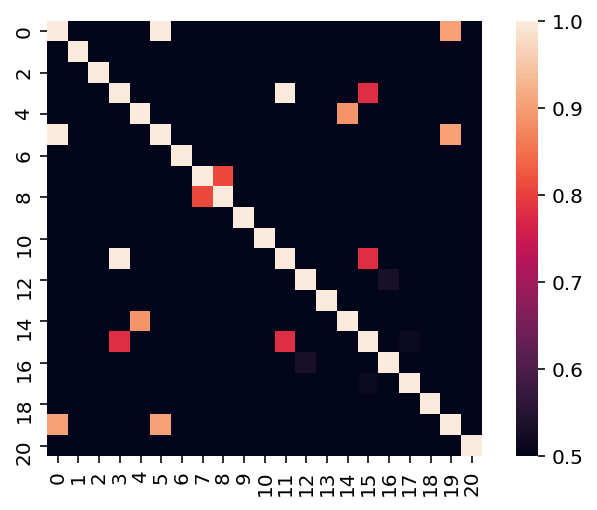

In [34]:
sns.heatmap(np.corrcoef(df_both.drop(columns=['_merge']).T), square=True, vmin=0.5)

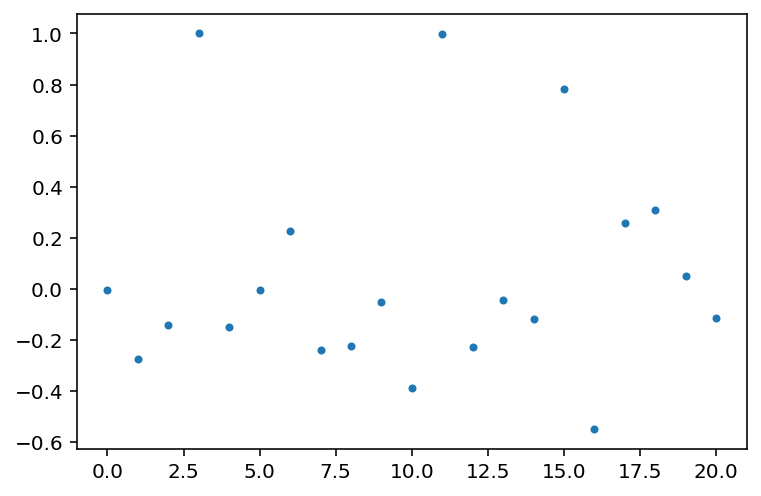

In [35]:
plt.plot(np.corrcoef(df_both.drop(columns=['_merge']).T)[3,:], '.')

We're reverse engineering what is in the info file!

OK! It looks like column **feature 9** (zero index) is the radius measurement, and **feature 6** (zero index) is the Teff measurement.  Let's replace those and then add the binary label!

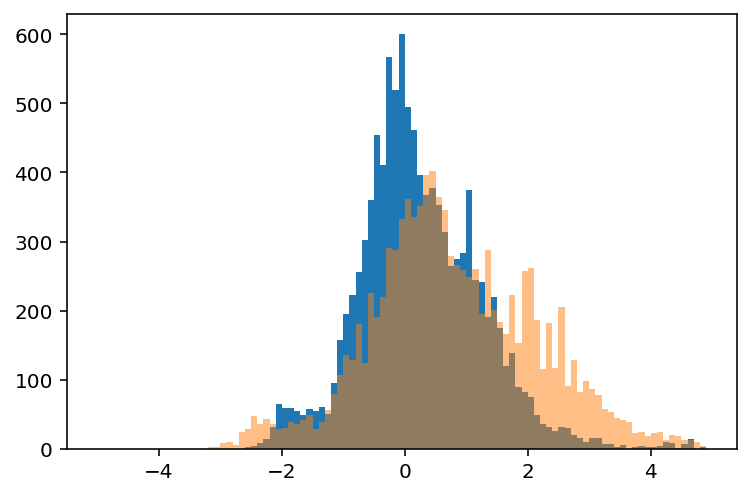

In [36]:
plt.hist(df_both[6], bins=np.arange(-5,5,0.1));
plt.hist(df_both['Teff_white'], bins=np.arange(-5,5,0.1), alpha=0.5);

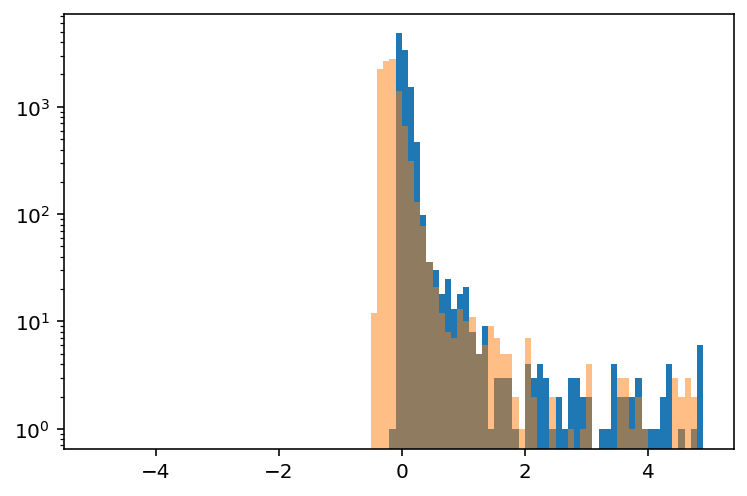

In [37]:
plt.hist(df_both[9], bins=np.arange(-5,5,0.1));
plt.hist(df_both['R_white'], bins=np.arange(-5,5,0.1), alpha=0.5);
plt.yscale('log')

The new stellar info shifts the distributions a little, which we expected.

In [38]:
def update_stellar_info(filename):
    current_info = np.load(filename)
    kicid = int(current_info[0])
    mask = df.KIC == kicid
    if mask.sum() == 1:
        current_info[6] = df.Teff_white[mask].values
        current_info[9] = df.R_white[mask].values
        new_info = np.hstack((current_info, np.reshape(df[mask][['Evol', 'Bin']].values, -1)))
    else:
        new_info = np.hstack((current_info, np.array([0,0])))
    fout = filename.replace('.npy', '_brg.npy').replace('/train/', '/train_brg/') #hack to avoid bash mv limit
    np.save(fout, new_info)

In [39]:
rerun = False

In [40]:
%%time
if rerun:
    for file in val_files:
        update_stellar_info(file)
    for file in train_files:
        update_stellar_info(file)
    for file in test_files:
        update_stellar_info(file)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


Done!